In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
from tqdm import tqdm

# Set up plotting
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]
warnings.filterwarnings('ignore')

/var/folders/vd/jprr4q2j7z1_0t5wkrskn09r0000gn/T/ipykernel_63285/2053241535.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
print("Loading and preprocessing data...")
df = pd.read_csv('../data/raw/drifting_longlines.csv')

# Basic preprocessing
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df = df[df['is_fishing'] >= 0]  # Remove no-data points
df['is_fishing_binary'] = (df['is_fishing'] > 0).astype(int)

# Display dataset info
print(f"Dataset shape after removing points with no fishing data: {df.shape}")
print(f"Number of unique vessels: {df['mmsi'].nunique()}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Fishing points: {df['is_fishing_binary'].sum()} ({df['is_fishing_binary'].mean()*100:.2f}%)")

Loading and preprocessing data...
Dataset shape after removing points with no fishing data: (219741, 12)
Number of unique vessels: 110
Date range: 2012-06-01 17:30:38 to 2016-01-01 04:40:54
Fishing points: 140167 (63.79%)



Segmenting vessel data into trips...


100%|██████████| 110/110 [00:00<00:00, 519.52it/s]



Identified 6034 distinct trips across 110 vessels

Trip summary statistics:
Average points per trip: 36.4
Average trip duration: 7.7 hours
Average fishing proportion: 0.69


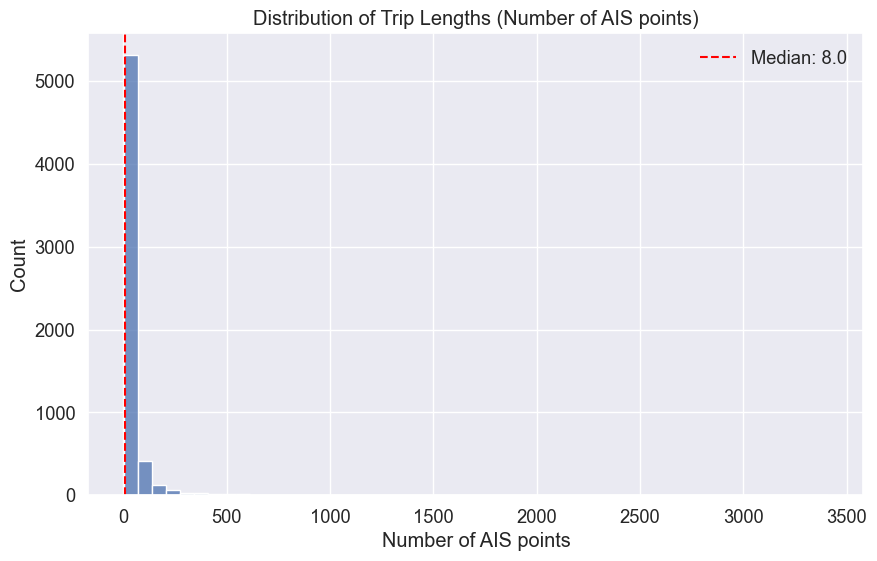

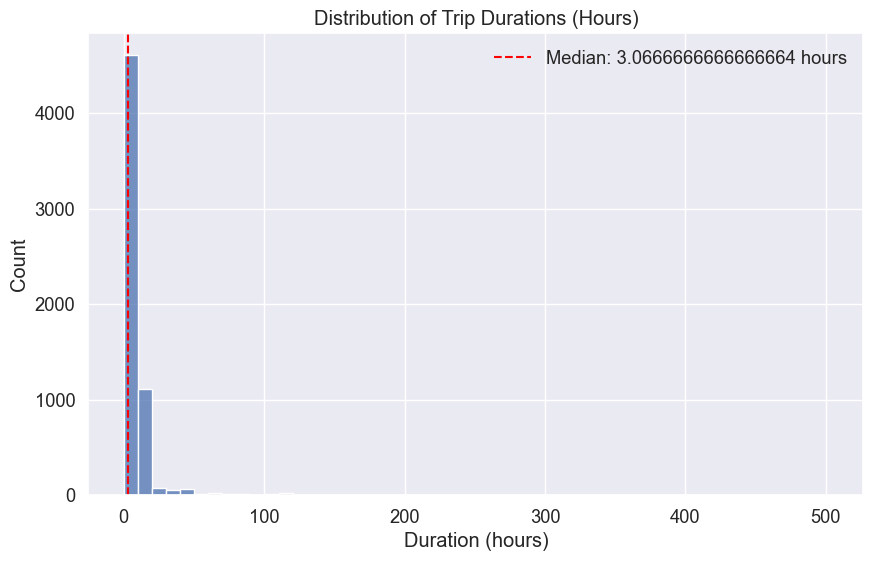

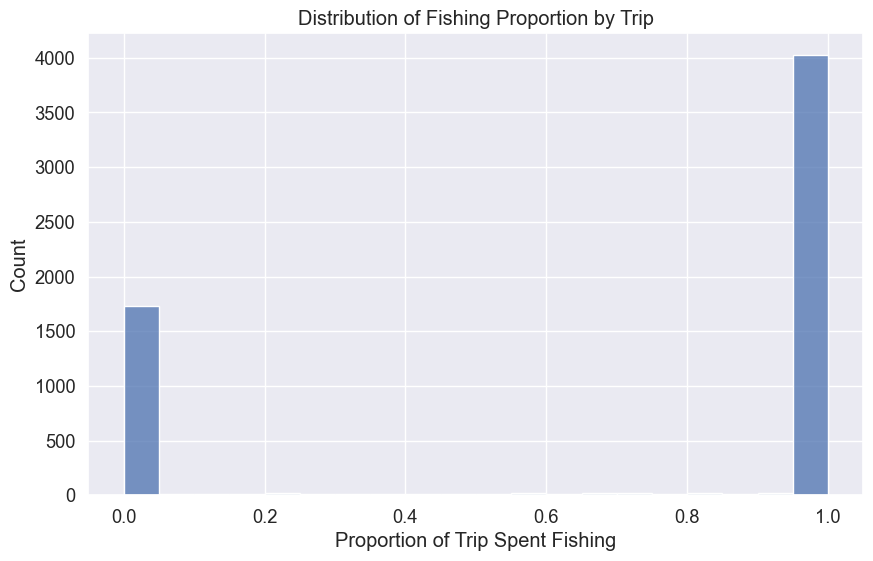


Visualizing example trips...


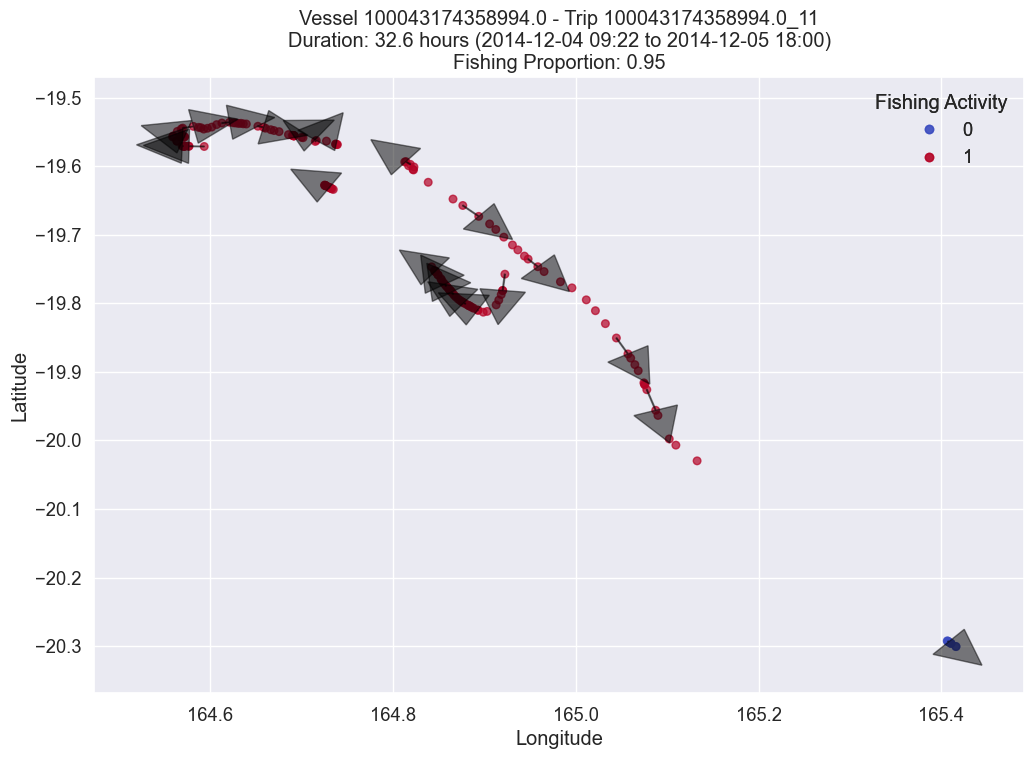

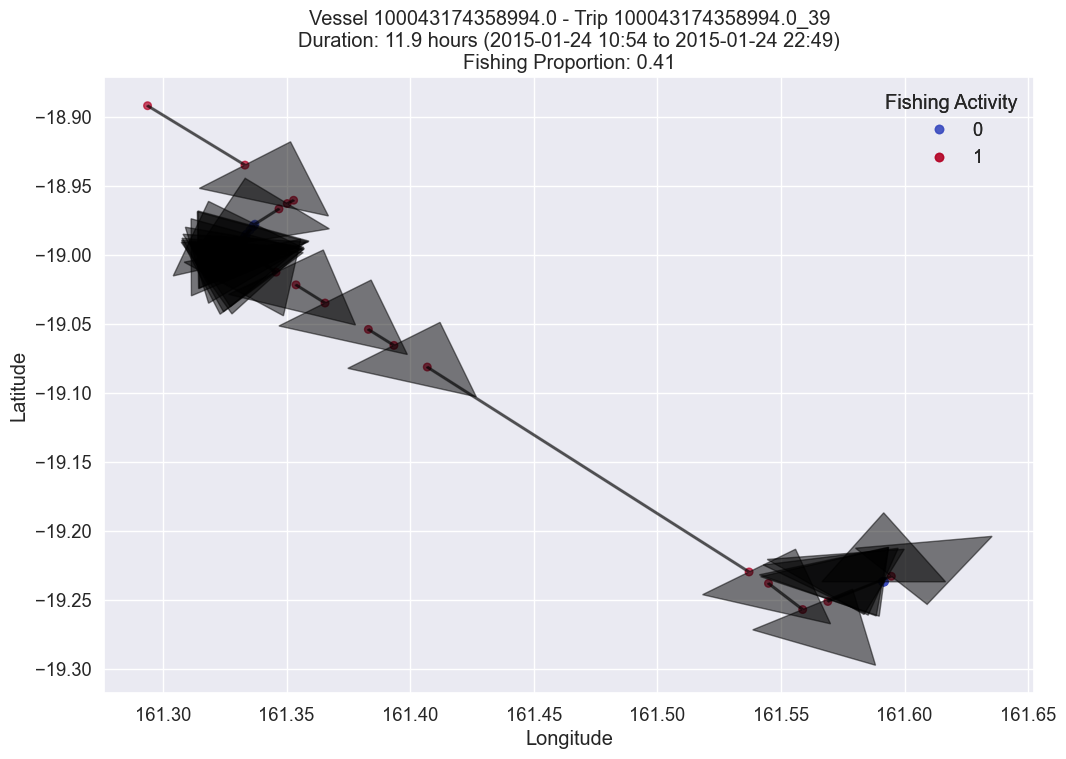

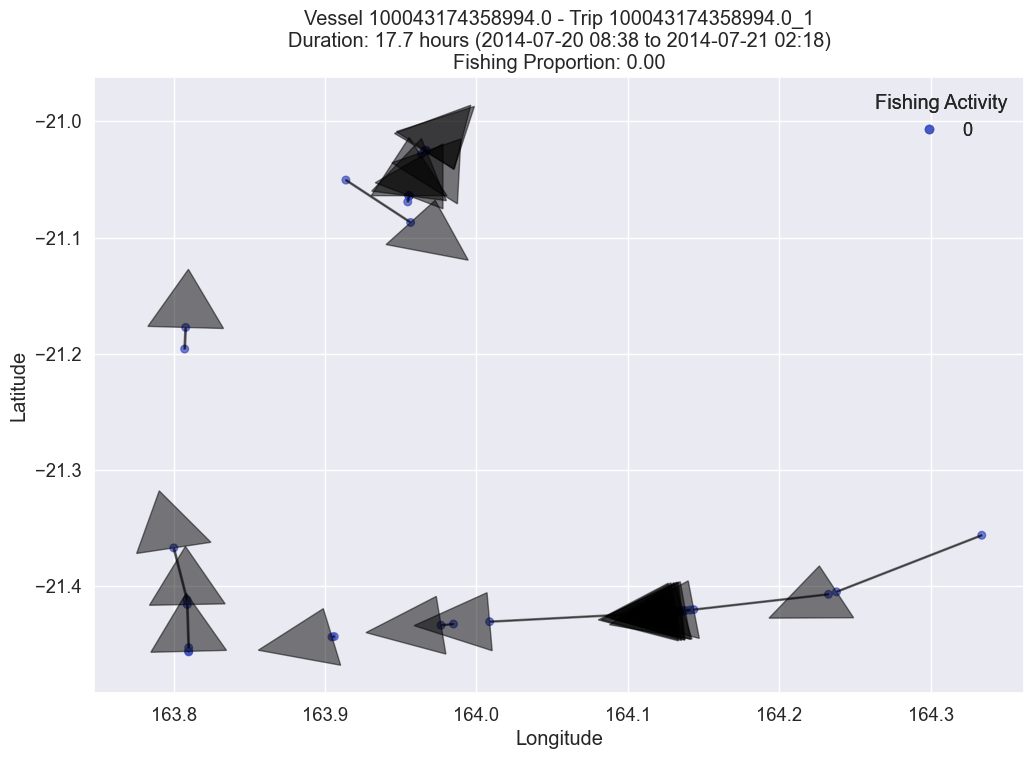

In [ ]:
def segment_vessel_trips(vessel_df, max_gap_hours=4):
    """
    Segment vessel data into trips based on time gaps.
    
    Parameters:
    -----------
    vessel_df : DataFrame
        Data for a single vessel, sorted by time
    max_gap_hours : float
        Maximum time gap (in hours) to consider points as part of the same trip
        
    Returns:
    --------
    DataFrame with trip_id column added
    """
    vessel_df = vessel_df.sort_values('datetime')
    
    vessel_df['time_diff'] = vessel_df['datetime'].diff().dt.total_seconds() / 3600
    
    vessel_df['new_trip'] = (vessel_df['time_diff'] > max_gap_hours) | (vessel_df['time_diff'].isna())
    
    vessel_df['trip_id'] = vessel_df['new_trip'].cumsum()
    vessel_df['trip_id'] = vessel_df['mmsi'].astype(str) + '_' + vessel_df['trip_id'].astype(str)
    
    return vessel_df

print("\nSegmenting vessel data into trips...")
df = df.sort_values(['mmsi', 'datetime'])
trip_segments = []

# Process each vessel separately
for mmsi, vessel_data in tqdm(df.groupby('mmsi')):
    trip_segments.append(segment_vessel_trips(vessel_data))

# Combine results
trip_df = pd.concat(trip_segments)
trip_df = trip_df.drop(['new_trip', 'time_diff'], axis=1)

# Summarize trip information
trip_summary = trip_df.groupby('trip_id').agg({
    'mmsi': 'first',
    'datetime': ['min', 'max', 'count'],
    'is_fishing_binary': ['mean', 'sum']
}).reset_index()

# Flatten multi-level columns
trip_summary.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in trip_summary.columns]

# Calculate trip duration in hours
trip_summary['duration_hours'] = (trip_summary['datetime_max'] - trip_summary['datetime_min']).dt.total_seconds() / 3600

print(f"\nIdentified {len(trip_summary)} distinct trips across {trip_df['mmsi'].nunique()} vessels")
print("\nTrip summary statistics:")
print(f"Average points per trip: {trip_summary['datetime_count'].mean():.1f}")
print(f"Average trip duration: {trip_summary['duration_hours'].mean():.1f} hours")
print(f"Average fishing proportion: {trip_summary['is_fishing_binary_mean'].mean():.2f}")

# Visualize trip length distribution
plt.figure(figsize=(10, 6))
sns.histplot(trip_summary['datetime_count'], bins=50)
plt.title('Distribution of Trip Lengths (Number of AIS points)')
plt.xlabel('Number of AIS points')
plt.ylabel('Count')
plt.axvline(trip_summary['datetime_count'].median(), color='red', linestyle='--', label=f'Median: {trip_summary["datetime_count"].median()}')
plt.legend()


# Visualize trip duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(trip_summary['duration_hours'], bins=50)
plt.title('Distribution of Trip Durations (Hours)')
plt.xlabel('Duration (hours)')
plt.ylabel('Count')
plt.axvline(trip_summary['duration_hours'].median(), color='red', linestyle='--', label=f'Median: {trip_summary["duration_hours"].median()} hours')
plt.legend()
plt.show()

# Visualize fishing proportion distribution
plt.figure(figsize=(10, 6))
sns.histplot(trip_summary['is_fishing_binary_mean'], bins=20)
plt.title('Distribution of Fishing Proportion by Trip')
plt.xlabel('Proportion of Trip Spent Fishing')
plt.ylabel('Count')
plt.show()

# Plot example trips for visual inspection
print("\nVisualizing example trips...")

def plot_vessel_trip(trip_id, output_filename=None):
    """Plot a single vessel trip trajectory colored by fishing activity"""
    trip_data = trip_df[trip_df['trip_id'] == trip_id].sort_values('datetime')
    
    if len(trip_data) < 5:  # Skip very short trips
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot trajectory
    scatter = ax.scatter(
        trip_data['lon'], 
        trip_data['lat'],
        c=trip_data['is_fishing_binary'],
        cmap='coolwarm',
        alpha=0.7,
        s=30
    )
    
    # Add arrows to show direction
    for i in range(0, len(trip_data)-1, max(1, len(trip_data)//20)):  # Add arrows periodically
        ax.arrow(
            trip_data.iloc[i]['lon'],
            trip_data.iloc[i]['lat'],
            trip_data.iloc[i+1]['lon'] - trip_data.iloc[i]['lon'],
            trip_data.iloc[i+1]['lat'] - trip_data.iloc[i]['lat'],
            head_width=0.05,
            head_length=0.05,
            fc='black',
            ec='black',
            alpha=0.5
        )
    
    # Add legend and labels
    legend = ax.legend(*scatter.legend_elements(), title="Fishing Activity")
    ax.add_artist(legend)
    
    vessel_id = trip_data['mmsi'].iloc[0]
    start_time = trip_data['datetime'].min().strftime('%Y-%m-%d %H:%M')
    end_time = trip_data['datetime'].max().strftime('%Y-%m-%d %H:%M')
    duration = (trip_data['datetime'].max() - trip_data['datetime'].min()).total_seconds() / 3600
    
    ax.set_title(f"Vessel {vessel_id} - Trip {trip_id}\n"
                 f"Duration: {duration:.1f} hours ({start_time} to {end_time})\n"
                 f"Fishing Proportion: {trip_data['is_fishing_binary'].mean():.2f}")
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    
    if output_filename:
        plt.savefig(output_filename)
        plt.close()
    else:
        plt.show()

# Plot a few example trips with different fishing proportions
# Select 3 trips: high fishing, mixed, and low fishing
high_fishing = trip_summary[trip_summary['is_fishing_binary_mean'] > 0.8].iloc[0]['trip_id']
mixed_fishing = trip_summary[(trip_summary['is_fishing_binary_mean'] > 0.4) & 
                          (trip_summary['is_fishing_binary_mean'] < 0.6)].iloc[0]['trip_id']
low_fishing = trip_summary[trip_summary['is_fishing_binary_mean'] < 0.2].iloc[0]['trip_id']

# Plot example trips
plot_vessel_trip(high_fishing)
plot_vessel_trip(mixed_fishing)
plot_vessel_trip(low_fishing)

In [6]:
print("\nEngineering behavioral features...")

def calculate_basic_stats(group, feature):
    """Calculate basic statistical features for a group"""
    return {
        f'{feature}_mean': group[feature].mean(),
        f'{feature}_std': group[feature].std(),
        f'{feature}_min': group[feature].min(),
        f'{feature}_max': group[feature].max(),
        f'{feature}_median': group[feature].median(),
        f'{feature}_q25': group[feature].quantile(0.25),
        f'{feature}_q75': group[feature].quantile(0.75),
    }

def calculate_movement_features(trip_data):
    """
    Calculate movement pattern features for a trip.
    
    Parameters:
    -----------
    trip_data : DataFrame
        Data for a single trip, sorted by time
        
    Returns:
    --------
    Dictionary of movement features
    """
    # Ensure data is sorted by time
    trip_data = trip_data.sort_values('datetime')
    
    if len(trip_data) < 3:  # Need at least 3 points for meaningful features
        return {}
    
    # Calculate time differences
    trip_data['time_diff'] = trip_data['datetime'].diff().dt.total_seconds() / 3600
    
    # Calculate distance between consecutive points (simplified)
    # For more accuracy, use haversine formula for geographic distances
    trip_data['lon_diff'] = trip_data['lon'].diff()
    trip_data['lat_diff'] = trip_data['lat'].diff()
    
    # Simple distance calculation (in degrees, not actual kilometers)
    trip_data['point_distance'] = np.sqrt(trip_data['lon_diff']**2 + trip_data['lat_diff']**2)
    
    # Speed calculated from points (crude approximation)
    trip_data['calculated_speed'] = np.where(
        trip_data['time_diff'] > 0,
        trip_data['point_distance'] / trip_data['time_diff'],
        0
    )
    
    # Course changes
    trip_data['course_diff'] = trip_data['course'].diff().abs()
    # Handle circular values (e.g., 350° to 10° should be 20° not 340°)
    trip_data['course_diff'] = np.minimum(trip_data['course_diff'], 360 - trip_data['course_diff'])
    
    # Movement metrics
    features = {}
    
    # Speed variability features
    features.update(calculate_basic_stats(trip_data, 'speed'))
    
    # Course variability
    features.update(calculate_basic_stats(trip_data, 'course_diff'))
    
    # Speed change rates
    features['speed_changes'] = trip_data['speed'].diff().abs().mean()
    
    # Count significant course changes (e.g., more than 30 degrees)
    features['major_course_changes'] = (trip_data['course_diff'] > 30).sum()
    features['course_changes_per_hour'] = features['major_course_changes'] / (
        (trip_data['datetime'].max() - trip_data['datetime'].min()).total_seconds() / 3600
    ) if (trip_data['datetime'].max() - trip_data['datetime'].min()).total_seconds() > 0 else 0
    
    # Overall trajectory features
    start_point = trip_data.iloc[0][['lat', 'lon']].values
    end_point = trip_data.iloc[-1][['lat', 'lon']].values
    
    # Direct distance from start to end (crude approximation)
    direct_distance = np.sqrt(((end_point - start_point)**2).sum())
    
    # Total distance traveled
    total_distance = trip_data['point_distance'].sum()
    
    # Path efficiency (ratio of direct distance to total distance traveled)
    # Close to 1 means straight path, close to 0 means meandering path
    features['path_efficiency'] = direct_distance / total_distance if total_distance > 0 else 1.0
    
    # Speed consistency
    features['speed_consistency'] = 1.0 - (trip_data['speed'].std() / trip_data['speed'].mean() 
                                          if trip_data['speed'].mean() > 0 else 0)
    
    # Average time between points
    features['avg_time_between_points'] = trip_data['time_diff'].mean()
    
    return features

def calculate_temporal_features(trip_data):
    """
    Calculate temporal context features for a trip.
    
    Parameters:
    -----------
    trip_data : DataFrame
        Data for a single trip, sorted by time
        
    Returns:
    --------
    Dictionary of temporal features
    """
    # Time of day distribution
    hours = trip_data['datetime'].dt.hour
    
    # Define time periods
    night = ((hours >= 0) & (hours < 6)).mean()  # 12am-6am
    morning = ((hours >= 6) & (hours < 12)).mean()  # 6am-12pm
    afternoon = ((hours >= 12) & (hours < 18)).mean()  # 12pm-6pm
    evening = ((hours >= 18) & (hours < 24)).mean()  # 6pm-12am
    
    # Return temporal features
    return {
        'night_proportion': night,
        'morning_proportion': morning,
        'afternoon_proportion': afternoon,
        'evening_proportion': evening,
        'hour_mean': hours.mean(),
        'hour_std': hours.std(),
        'weekend_proportion': (trip_data['datetime'].dt.dayofweek >= 5).mean(),
    }

def calculate_spatial_features(trip_data):
    """
    Calculate spatial context features for a trip.
    
    Parameters:
    -----------
    trip_data : DataFrame
        Data for a single trip
        
    Returns:
    --------
    Dictionary of spatial features
    """
    # Distance from shore/port statistics
    features = {}
    
    # Basic statistics for distances
    features.update(calculate_basic_stats(trip_data, 'distance_from_shore'))
    features.update(calculate_basic_stats(trip_data, 'distance_from_port'))
    
    # Range and coverage
    features['lat_range'] = trip_data['lat'].max() - trip_data['lat'].min()
    features['lon_range'] = trip_data['lon'].max() - trip_data['lon'].min()
    features['area_covered'] = features['lat_range'] * features['lon_range']
    
    return features

# Process each trip to extract features
trip_features = []

for trip_id, trip_data in tqdm(trip_df.groupby('trip_id')):
    # Skip very short trips
    if len(trip_data) < 5:
        continue
        
    # Basic trip metadata
    trip_info = {
        'trip_id': trip_id,
        'mmsi': trip_data['mmsi'].iloc[0],
        'start_time': trip_data['datetime'].min(),
        'end_time': trip_data['datetime'].max(),
        'duration_hours': (trip_data['datetime'].max() - trip_data['datetime'].min()).total_seconds() / 3600,
        'point_count': len(trip_data),
        'fishing_proportion': trip_data['is_fishing_binary'].mean(),
        'is_fishing': trip_data['is_fishing_binary'].mean() > 0.5,  # Binary trip label
    }
    
    # Calculate different feature groups
    movement_features = calculate_movement_features(trip_data)
    temporal_features = calculate_temporal_features(trip_data)
    spatial_features = calculate_spatial_features(trip_data)
    
    # Combine all features
    all_features = {**trip_info, **movement_features, **temporal_features, **spatial_features}
    
    # Add to results
    trip_features.append(all_features)

# Convert to DataFrame
trip_features_df = pd.DataFrame(trip_features)

# Display feature statistics
print(f"\nExtracted {len(trip_features_df.columns)} features for {len(trip_features_df)} trips")
print("\nSample of engineered features:")
print(trip_features_df.iloc[:3, :10])  # Show first 3 rows, first 10 columns

# Save features for later use
trip_features_df.to_csv('engineered_trip_features.csv', index=False)
print("Saved engineered features to 'engineered_trip_features.csv'")


Engineering behavioral features...


100%|██████████| 6034/6034 [00:14<00:00, 424.25it/s]


Extracted 52 features for 3591 trips

Sample of engineered features:
                trip_id          mmsi          start_time            end_time  \
0   100043174358994.0_1  1.000432e+14 2014-07-20 08:38:09 2014-07-21 02:18:17   
1  100043174358994.0_10  1.000432e+14 2014-10-25 10:48:34 2014-10-27 05:39:54   
2  100043174358994.0_11  1.000432e+14 2014-12-04 09:22:07 2014-12-05 18:00:45   

   duration_hours  point_count  fishing_proportion  is_fishing  speed_mean  \
0       17.668889           44            0.000000       False    5.709091   
1       42.855556          219            0.086758       False    5.789498   
2       32.643889          167            0.946108        True    4.249102   

   speed_std  
0   3.044081  
1   2.921312  
2   2.449364  
Saved engineered features to 'engineered_trip_features.csv'



Analyzing feature distributions and relationships...
Generating pairplot of key features (this may take a while)...


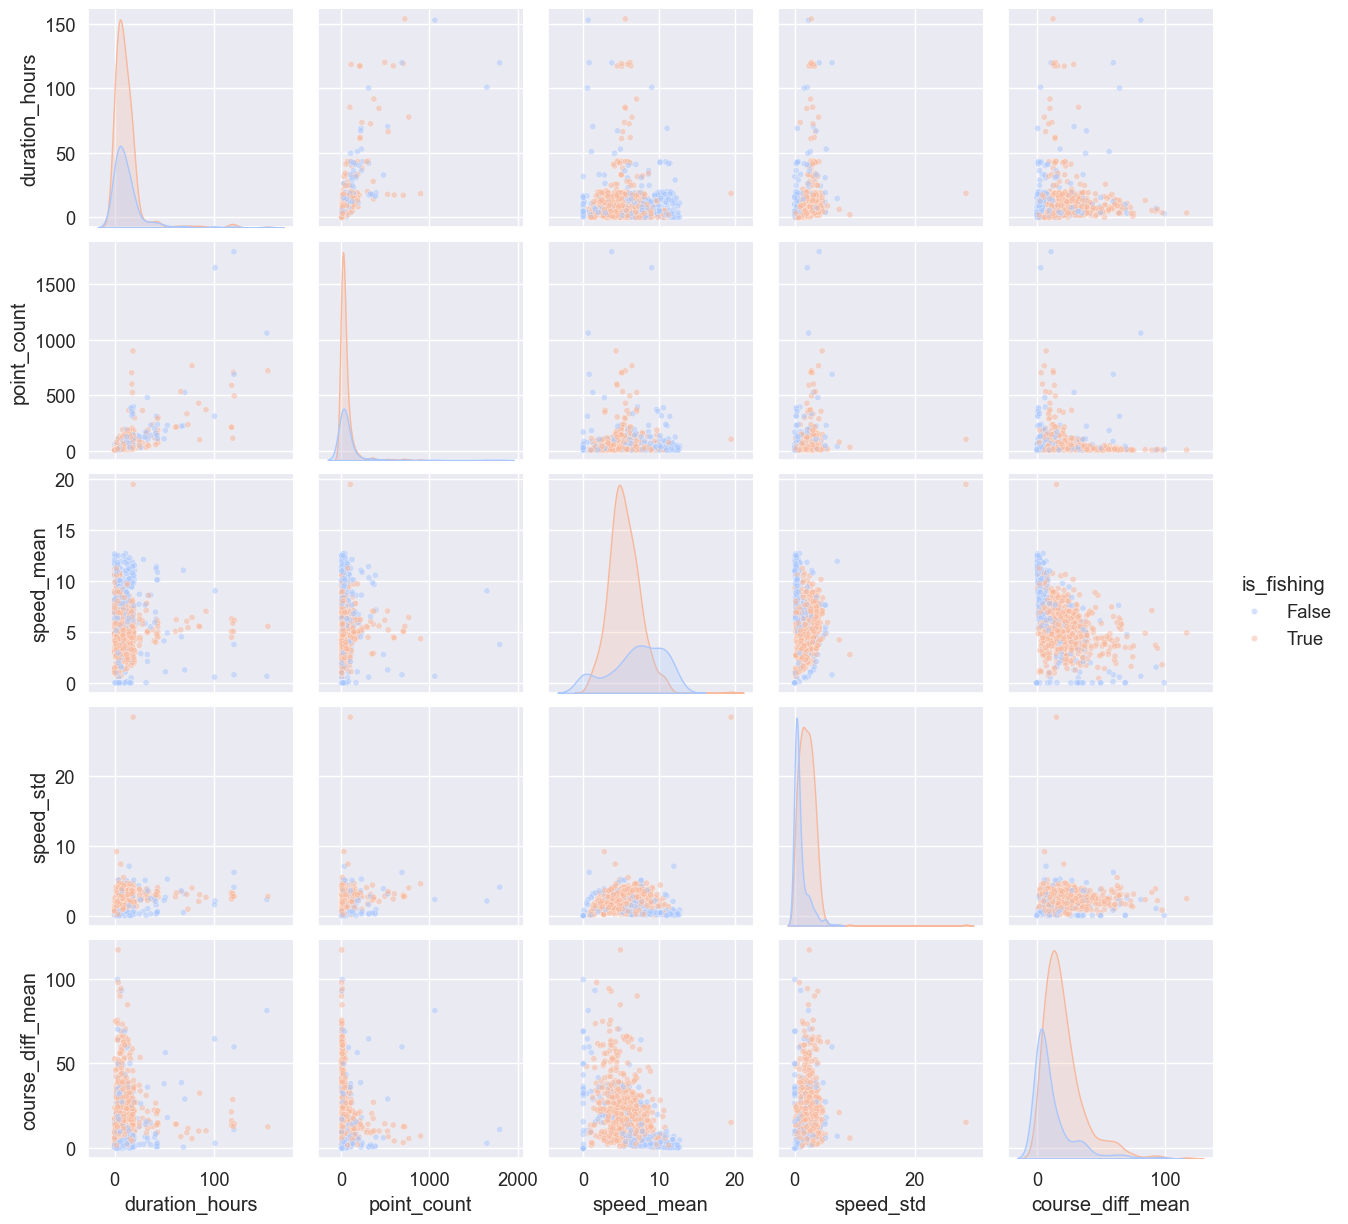

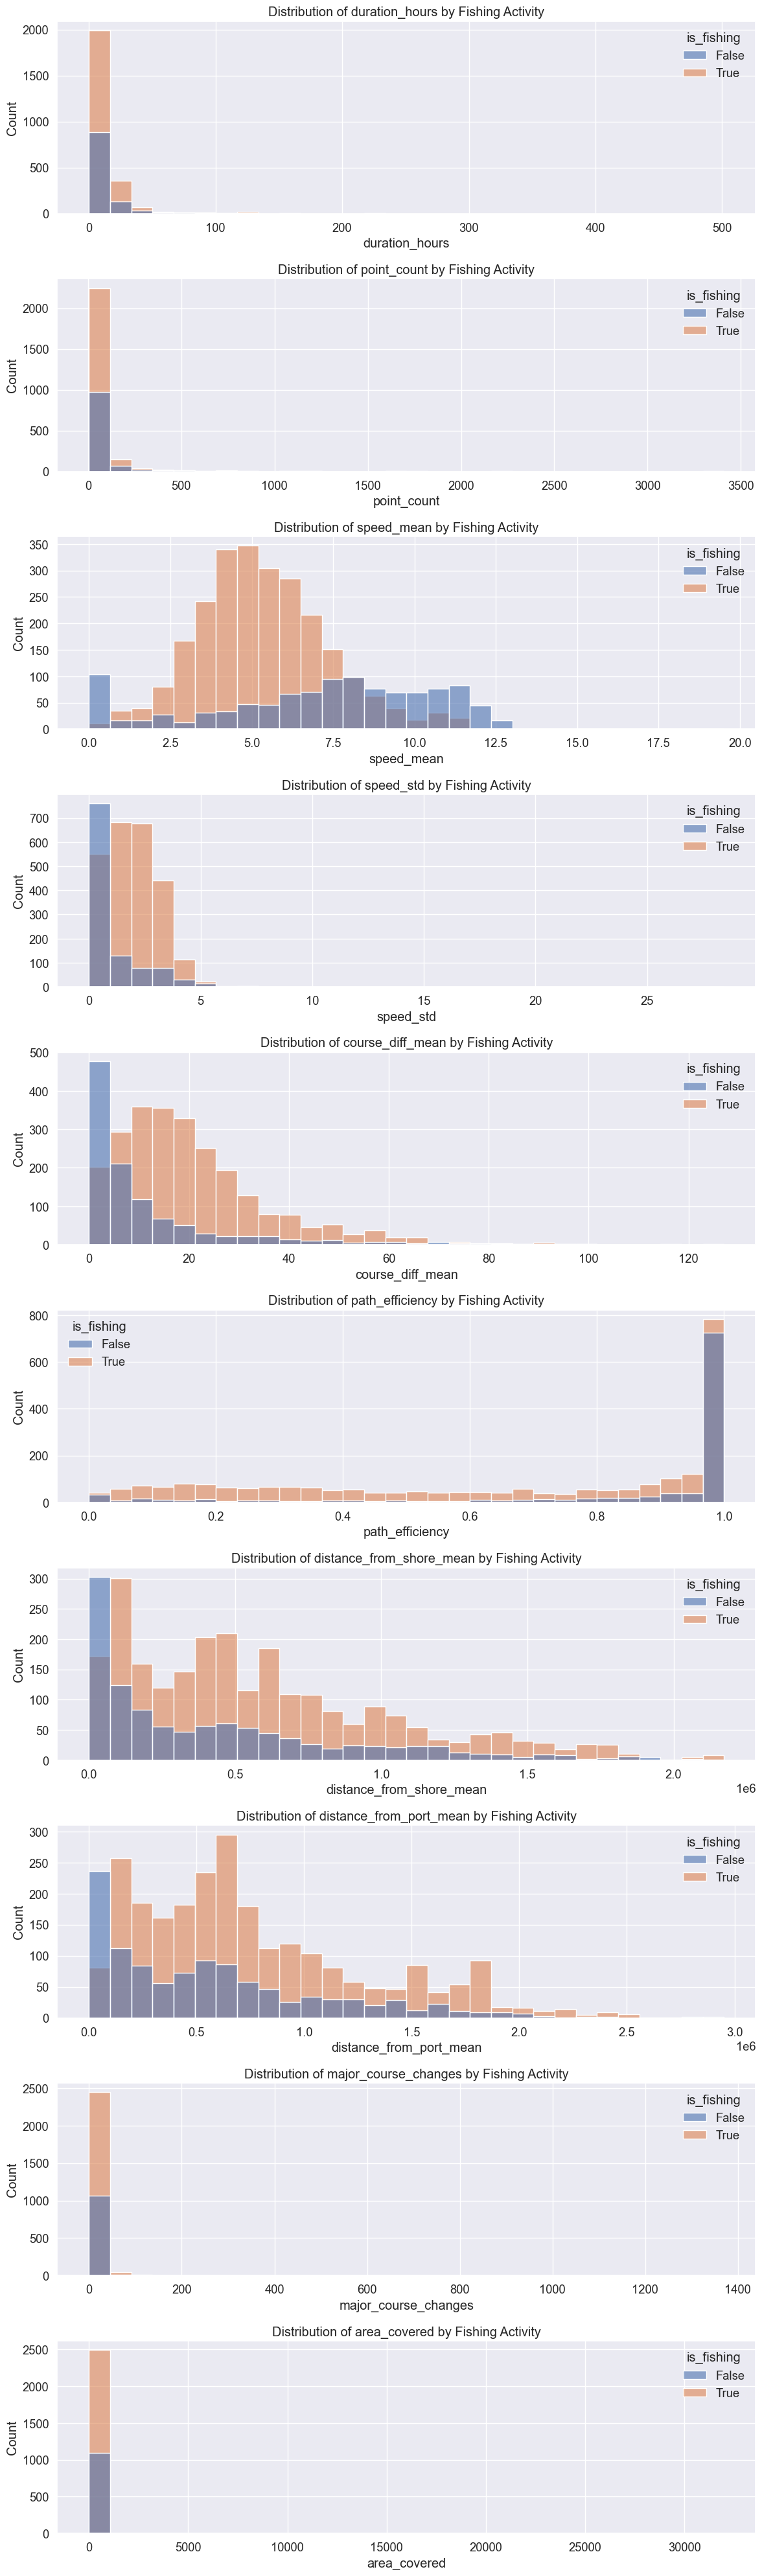


Top features correlated with fishing proportion:
fishing_proportion         1.000000
course_diff_max            0.415683
speed_changes              0.385197
course_diff_std            0.384203
speed_std                  0.318184
course_diff_mean           0.271274
distance_from_shore_min    0.187044
distance_from_port_min     0.182328
distance_from_shore_q25    0.180857
distance_from_port_q25     0.173783
Name: fishing_proportion, dtype: float64

Bottom features correlated with fishing proportion:
lon_range                 -0.072733
lat_range                 -0.094697
speed_q75                 -0.173110
distance_from_shore_std   -0.230442
path_efficiency           -0.270012
distance_from_port_std    -0.276081
speed_median              -0.276274
speed_mean                -0.308374
speed_q25                 -0.363011
speed_min                 -0.465696
Name: fishing_proportion, dtype: float64


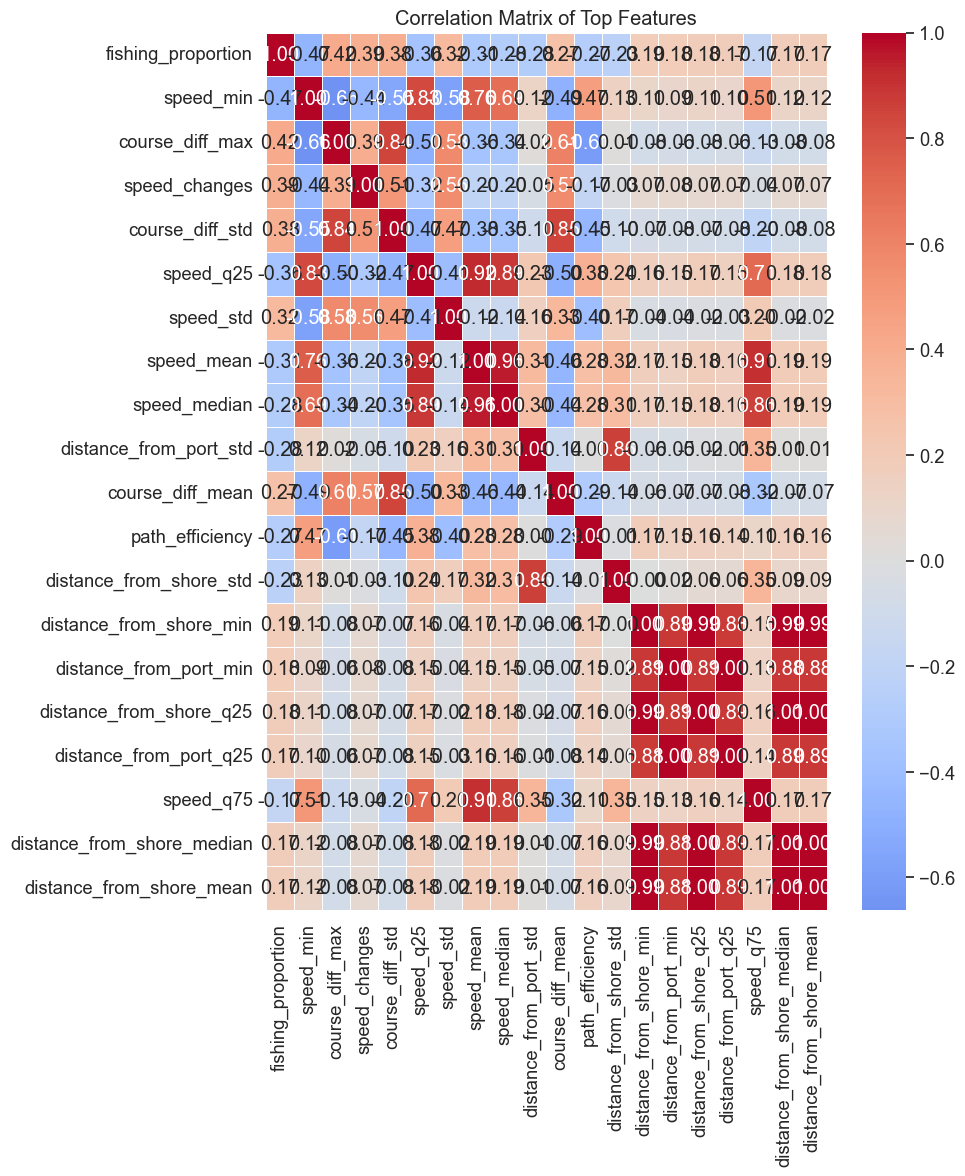

In [7]:
print("\nAnalyzing feature distributions and relationships...")

# Select key features for visualization
key_features = [
    'duration_hours', 'point_count', 'speed_mean', 'speed_std', 
    'course_diff_mean', 'path_efficiency', 'distance_from_shore_mean',
    'distance_from_port_mean', 'major_course_changes', 'area_covered'
]

# Create pairplot of key features colored by fishing activity
print("Generating pairplot of key features (this may take a while)...")
sns.pairplot(
    trip_features_df.sample(min(1000, len(trip_features_df))),  # Sample to keep plot manageable
    vars=key_features[:5],  # Use first 5 features for readability
    hue='is_fishing',
    palette='coolwarm',
    plot_kws={'alpha': 0.5, 's': 20},
    diag_kind='kde'
)
plt.show()

# Analyze feature distributions by fishing activity
fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))

for i, feature in enumerate(key_features):
    if feature in trip_features_df.columns:
        sns.histplot(
            data=trip_features_df,
            x=feature,
            hue='is_fishing',
            bins=30,
            alpha=0.6,
            ax=axes[i]
        )
        axes[i].set_title(f'Distribution of {feature} by Fishing Activity')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Calculate feature correlations with fishing proportion
feature_correlations = trip_features_df.drop(['trip_id', 'mmsi', 'start_time', 'end_time', 'is_fishing'], axis=1)
feature_correlations = feature_correlations.corr()['fishing_proportion'].sort_values(ascending=False)

print("\nTop features correlated with fishing proportion:")
print(feature_correlations.head(10))
print("\nBottom features correlated with fishing proportion:")
print(feature_correlations.tail(10))

# Visualize top feature correlations
plt.figure(figsize=(10, 12))
top_features = feature_correlations.abs().sort_values(ascending=False).head(20).index
correlation_matrix = trip_features_df[top_features].corr()

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

In [8]:
print("\nApplying unsupervised learning techniques...")

# Prepare data for clustering
cluster_features = trip_features_df.drop(['trip_id', 'mmsi', 'start_time', 'end_time', 'is_fishing'], axis=1)

# Handle missing values by imputing with median
for col in cluster_features.columns:
    if cluster_features[col].isna().any():
        cluster_features[col] = cluster_features[col].fillna(cluster_features[col].median())

# Standardize features (important for clustering)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

# K-means clustering
print("\nPerforming K-means clustering...")
k_values = range(2, 11)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

# Plot elbow curve to help determine optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('kmeans_elbow_curve.png')
plt.close()

# Select optimal k based on elbow curve (this is a simplification)
optimal_k = 4  # This should be determined by examining the elbow curve

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
trip_features_df['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze clusters
cluster_stats = trip_features_df.groupby('cluster').agg({
    'fishing_proportion': ['mean', 'std'],
    'is_fishing': 'mean',
    'duration_hours': 'mean',
    'speed_mean': 'mean',
    'path_efficiency': 'mean',
    'distance_from_shore_mean': 'mean',
    'mmsi': 'count'
})

print("\nCluster statistics:")
print(cluster_stats)

# Visualize clusters in feature space using PCA
print("\nReducing dimensionality with PCA for visualization...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=trip_features_df['cluster'],
    cmap='viridis',
    alpha=0.6,
    s=30
)

plt.colorbar(scatter, label='Cluster')
plt.title('PCA Projection of Trip Features Colored by Cluster')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True)
plt.savefig('cluster_pca_projection.png')
plt.close()

# Visualize clusters vs. fishing proportion
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='fishing_proportion', data=trip_features_df)
plt.title('Fishing Proportion by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fishing Proportion')
plt.grid(True)
plt.savefig('cluster_fishing_boxplot.png')
plt.close()

# Plot key features by cluster
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

key_cluster_features = ['speed_mean', 'path_efficiency', 'distance_from_shore_mean', 'duration_hours']

for i, feature in enumerate(key_cluster_features):
    sns.boxplot(x='cluster', y=feature, data=trip_features_df, ax=axes[i])
    axes[i].set_title(f'{feature} by Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)
    axes[i].grid(True)

plt.tight_layout()
plt.savefig('cluster_feature_comparison.png')
plt.close()


Applying unsupervised learning techniques...

Performing K-means clustering...

Cluster statistics:
        fishing_proportion           is_fishing duration_hours speed_mean  \
                      mean       std       mean           mean       mean   
cluster                                                                     
0                 0.826593  0.351144   0.834751      15.560149   4.741143   
1                 0.819135  0.373584   0.819809      11.079791   6.062873   
2                 0.707332  0.443532   0.708955      11.623518   3.139426   
3                 0.292028  0.445386   0.290822       7.820921   8.825427   

        path_efficiency distance_from_shore_mean  mmsi  
                   mean                     mean count  
cluster                                                 
0              0.586920             3.077999e+05  1646  
1              0.753129             1.188969e+06   838  
2              0.589887             3.301022e+05   268  
3              0.

In [9]:

print("\nTraining model with engineered features...")

# Prepare modeling data
X = trip_features_df.drop(['trip_id', 'mmsi', 'start_time', 'end_time', 
                          'is_fishing', 'fishing_proportion', 'cluster'], axis=1)
y = trip_features_df['is_fishing']

# Handle missing values by imputing with median
for col in X.columns:
    if X[col].isna().any():
        X[col] = X[col].fillna(X[col].median())

# Split data by vessel (vessel-based splitting)
vessels = trip_features_df['mmsi'].unique()
train_vessels, test_vessels = train_test_split(vessels, test_size=0.2, random_state=42)

# Create train/test sets
X_train = X[trip_features_df['mmsi'].isin(train_vessels)]
X_test = X[trip_features_df['mmsi'].isin(test_vessels)]
y_train = y[trip_features_df['mmsi'].isin(train_vessels)]
y_test = y[trip_features_df['mmsi'].isin(test_vessels)]

print(f"Training data: {X_train.shape[0]} samples")
print(f"Testing data: {X_test.shape[0]} samples")

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nModel performance with engineered features:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 most important features:")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()



Training model with engineered features...
Training data: 2783 samples
Testing data: 808 samples

Model performance with engineered features:
              precision    recall  f1-score   support

       False       0.85      0.62      0.72       220
        True       0.87      0.96      0.91       588

    accuracy                           0.87       808
   macro avg       0.86      0.79      0.81       808
weighted avg       0.86      0.87      0.86       808


Confusion Matrix:
[[136  84]
 [ 24 564]]

Top 15 most important features:
                    feature  importance
4                 speed_min    0.065147
18  course_changes_per_hour    0.053950
7                 speed_q25    0.047652
20        speed_consistency    0.047315
3                 speed_std    0.043532
10          course_diff_std    0.041686
45             area_covered    0.037980
41   distance_from_port_q25    0.036996
34  distance_from_shore_q25    0.036438
31  distance_from_shore_min    0.033985
44             

In [10]:
print("\nSummarizing findings and next steps...")

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nEngineered features model accuracy: {accuracy:.4f}")

# Print overall summary
print("\n----- Project Summary -----")
print(f"1. Processed {len(trip_df)} AIS points into {len(trip_features_df)} distinct vessel trips")
print(f"2. Engineered {len(X.columns)} behavioral features capturing movement patterns")
print(f"3. Identified {optimal_k} natural vessel behavior clusters through unsupervised learning")
print(f"4. Achieved {accuracy:.2%} accuracy using vessel-based evaluation")
print(f"5. Key predictive features: {', '.join(feature_importance.head(5)['feature'].tolist())}")



Summarizing findings and next steps...

Engineered features model accuracy: 0.8663

----- Project Summary -----
1. Processed 219741 AIS points into 3591 distinct vessel trips
2. Engineered 46 behavioral features capturing movement patterns
3. Identified 4 natural vessel behavior clusters through unsupervised learning
4. Achieved 86.63% accuracy using vessel-based evaluation
5. Key predictive features: speed_min, course_changes_per_hour, speed_q25, speed_consistency, speed_std


In [11]:
"""
Based on our analysis, we need to select the most important and interpretable features.
We'll validate that our selected features make intuitive sense for fishing detection
and reduce the feature set to prevent overfitting.
"""

print("\nValidating and selecting features...")

# Analyze feature importance in detail
print("\nTop 20 most important features:")
print(feature_importance.head(20))

# Group features by category for analysis
feature_categories = {
    'Speed Features': [f for f in feature_importance['feature'] if 'speed' in f],
    'Course Features': [f for f in feature_importance['feature'] if 'course' in f],
    'Distance Features': [f for f in feature_importance['feature'] if 'distance' in f],
    'Temporal Features': [f for f in feature_importance['feature'] if any(x in f for x in ['hour', 'night', 'morning', 'afternoon', 'evening', 'weekend'])],
    'Movement Features': [f for f in feature_importance['feature'] if any(x in f for x in ['path_efficiency', 'changes_per_hour', 'area_covered'])],
    'Trip Features': [f for f in feature_importance['feature'] if any(x in f for x in ['duration', 'point_count'])]
}

# Analyze importance by category
print("\nFeature importance by category:")
for category, features in feature_categories.items():
    if features:
        category_importance = feature_importance[feature_importance['feature'].isin(features)]['importance'].sum()
        top_feature = feature_importance[feature_importance['feature'].isin(features)].iloc[0] if len([f for f in features if f in feature_importance['feature'].values]) > 0 else None
        print(f"{category}: {category_importance:.3f} total importance")
        if top_feature is not None:
            print(f"  - Top feature: {top_feature['feature']} ({top_feature['importance']:.3f})")

# Select features based on importance and interpretability
print("\nSelecting final feature set...")

# Criteria for feature selection:
# 1. High importance (top 15-20 features)
# 2. Interpretable for fishing behavior
# 3. Not highly correlated with each other

# Start with top 15 features by importance
selected_features = feature_importance.head(15)['feature'].tolist()

print(f"\nSelected {len(selected_features)} features:")
for i, feature in enumerate(selected_features, 1):
    importance_score = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
    print(f"{i:2d}. {feature:<25} (importance: {importance_score:.3f})")






Validating and selecting features...

Top 20 most important features:
                    feature  importance
4                 speed_min    0.065147
18  course_changes_per_hour    0.053950
7                 speed_q25    0.047652
20        speed_consistency    0.047315
3                 speed_std    0.043532
10          course_diff_std    0.041686
45             area_covered    0.037980
41   distance_from_port_q25    0.036996
34  distance_from_shore_q25    0.036438
31  distance_from_shore_min    0.033985
44                lon_range    0.027995
38   distance_from_port_min    0.027120
12          course_diff_max    0.027103
9          course_diff_mean    0.026589
2                speed_mean    0.025488
0            duration_hours    0.023344
36  distance_from_port_mean    0.022823
16            speed_changes    0.022521
19          path_efficiency    0.022126
6              speed_median    0.021474

Feature importance by category:
Speed Features: 0.298 total importance
  - Top feature: 

In [12]:

"""
Train the final model using our selected features and evaluate performance.
This will be our production model for the pipeline.
"""

print("\nTraining final model with selected features...")

# Prepare data with selected features only
X_selected = X[selected_features]
print(f"Using {len(selected_features)} features for final model")

# Verify no missing values in selected features
missing_in_selected = X_selected.isnull().sum()
if missing_in_selected.sum() > 0:
    print("Handling missing values in selected features:")
    print(missing_in_selected[missing_in_selected > 0])
    # Fill with median for any remaining missing values
    for col in X_selected.columns:
        if X_selected[col].isnull().any():
            X_selected[col] = X_selected[col].fillna(X_selected[col].median())

# Split data using same vessel-based approach
X_train_final = X_selected[trip_features_df['mmsi'].isin(train_vessels)]
X_test_final = X_selected[trip_features_df['mmsi'].isin(test_vessels)]
y_train_final = y[trip_features_df['mmsi'].isin(train_vessels)]
y_test_final = y[trip_features_df['mmsi'].isin(test_vessels)]

print(f"Training data: {X_train_final.shape[0]} samples, {X_train_final.shape[1]} features")
print(f"Testing data: {X_test_final.shape[0]} samples, {X_test_final.shape[1]} features")

# Train final Random Forest model
print("\nTraining final Random Forest model...")
final_model = RandomForestClassifier(
    n_estimators=200,  # Increase trees for better performance
    max_depth=10,      # Limit depth to prevent overfitting
    min_samples_split=10,  # Require minimum samples to split
    random_state=42
)

final_model.fit(X_train_final, y_train_final)

# Make predictions
y_pred_final = final_model.predict(X_test_final)
y_prob_final = final_model.predict_proba(X_test_final)[:, 1]

# Evaluate final model
print("\nFinal model performance:")
print(classification_report(y_test_final, y_pred_final))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_final, y_pred_final))

final_accuracy = accuracy_score(y_test_final, y_pred_final)
print(f"\nFinal model accuracy: {final_accuracy:.4f}")

# Feature importance for final model
final_feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFinal model feature importance:")
print(final_feature_importance)

# Visualize final feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=final_feature_importance)
plt.title('Final Model Feature Importance')
plt.tight_layout()
plt.savefig('final_feature_importance.png')
plt.close()




Training final model with selected features...
Using 15 features for final model
Training data: 2783 samples, 15 features
Testing data: 808 samples, 15 features

Training final Random Forest model...

Final model performance:
              precision    recall  f1-score   support

       False       0.85      0.60      0.70       220
        True       0.86      0.96      0.91       588

    accuracy                           0.86       808
   macro avg       0.86      0.78      0.81       808
weighted avg       0.86      0.86      0.85       808


Confusion Matrix:
[[131  89]
 [ 23 565]]

Final model accuracy: 0.8614

Final model feature importance:
                    feature  importance
0                 speed_min    0.111516
3         speed_consistency    0.098421
6              area_covered    0.078303
2                 speed_q25    0.076828
11   distance_from_port_min    0.071824
8   distance_from_shore_q25    0.066721
5           course_diff_std    0.064427
9   distance_from_sho

In [13]:
"""
Perform cross-validation to get a better estimate of model performance
and validate that our results are consistent across different vessel splits.
"""

print("\nPerforming cross-validation...")

from sklearn.model_selection import GroupKFold

# Set up GroupKFold cross-validation using vessel IDs as groups
gkf = GroupKFold(n_splits=5)
vessel_groups = trip_features_df['mmsi']

# Perform cross-validation
cv_scores = cross_val_score(
    final_model, 
    X_selected, 
    y, 
    groups=vessel_groups,
    cv=gkf,
    scoring='accuracy'
)

print(f"\nCross-validation results:")
print(f"Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Individual fold scores: {cv_scores}")

# Also calculate F1 scores for cross-validation
cv_f1_scores = cross_val_score(
    final_model, 
    X_selected, 
    y, 
    groups=vessel_groups,
    cv=gkf,
    scoring='f1'
)

print(f"\nF1 Cross-validation results:")
print(f"Mean F1: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std() * 2:.4f})")






Performing cross-validation...

Cross-validation results:
Mean accuracy: 0.8819 (+/- 0.0310)
Individual fold scores: [0.8816156  0.88284519 0.89958159 0.89181692 0.85376045]

F1 Cross-validation results:
Mean F1: 0.9182 (+/- 0.0212)


In [14]:
"""
Interpret the final model results in business terms and validate that
our model captures meaningful fishing behavior patterns.
"""

print("\nInterpreting model results for business insights...")

# Analyze predictions by fishing probability ranges
prob_ranges = [
    (0.0, 0.3, "Low probability"),
    (0.3, 0.7, "Medium probability"), 
    (0.7, 1.0, "High probability")
]

print("\nPrediction distribution by probability ranges:")
for low, high, label in prob_ranges:
    mask = (y_prob_final >= low) & (y_prob_final < high)
    count = mask.sum()
    actual_fishing_rate = y_test_final[mask].mean() if count > 0 else 0
    print(f"{label} ({low}-{high}): {count} trips, actual fishing rate: {actual_fishing_rate:.2%}")

# Analyze model performance by different vessel characteristics
print("\nModel performance by trip characteristics:")

# Performance by trip duration
test_data = trip_features_df[trip_features_df['mmsi'].isin(test_vessels)].copy()
test_data['y_pred'] = y_pred_final
test_data['y_prob'] = y_prob_final

# Analyze by duration quartiles
duration_quartiles = test_data['duration_hours'].quantile([0.25, 0.5, 0.75])
print(f"\nPerformance by trip duration:")
print(f"Q1 (short): <{duration_quartiles[0.25]:.1f}h")
print(f"Q2 (medium): {duration_quartiles[0.25]:.1f}-{duration_quartiles[0.5]:.1f}h") 
print(f"Q3 (long): {duration_quartiles[0.5]:.1f}-{duration_quartiles[0.75]:.1f}h")
print(f"Q4 (very long): >{duration_quartiles[0.75]:.1f}h")

# Model confidence analysis
confidence_thresholds = {
    'high': 0.9,
    'medium': 0.7,
    'low': 0.5
}

print(f"\nModel confidence analysis:")
for conf_level, threshold in confidence_thresholds.items():
    high_conf_mask = (y_prob_final >= threshold) | (y_prob_final <= (1-threshold))
    high_conf_count = high_conf_mask.sum()
    high_conf_accuracy = accuracy_score(y_test_final[high_conf_mask], y_pred_final[high_conf_mask]) if high_conf_count > 0 else 0
    
    print(f"{conf_level.capitalize()} confidence (prob >{threshold} or <{1-threshold}): {high_conf_count} predictions, accuracy: {high_conf_accuracy:.3f}")




Interpreting model results for business insights...

Prediction distribution by probability ranges:
Low probability (0.0-0.3): 116 trips, actual fishing rate: 7.76%
Medium probability (0.3-0.7): 117 trips, actual fishing rate: 58.97%
High probability (0.7-1.0): 575 trips, actual fishing rate: 88.70%

Model performance by trip characteristics:

Performance by trip duration:
Q1 (short): <3.6h
Q2 (medium): 3.6-8.1h
Q3 (long): 8.1-13.7h
Q4 (very long): >13.7h

Model confidence analysis:
High confidence (prob >0.9 or <0.09999999999999998): 463 predictions, accuracy: 0.911
Medium confidence (prob >0.7 or <0.30000000000000004): 691 predictions, accuracy: 0.893
Low confidence (prob >0.5 or <0.5): 808 predictions, accuracy: 0.861


In [15]:

"""
Prepare the model for deployment in the pipeline by saving it and
creating the necessary metadata files.
"""

print("\nPreparing model for deployment...")

import joblib
import json
import os

# Create models directory
os.makedirs('models', exist_ok=True)

# Save the trained model
model_path = 'models/fishing_classifier.joblib'
joblib.dump(final_model, model_path)
print(f"Saved model to {model_path}")

# Save feature names and metadata
feature_metadata = {
    'feature_names': selected_features,
    'feature_count': len(selected_features),
    'model_type': 'RandomForestClassifier',
    'model_version': '1.0',
    'training_date': datetime.now().isoformat(),
    'training_accuracy': float(final_accuracy),
    'cv_accuracy_mean': float(cv_scores.mean()),
    'cv_accuracy_std': float(cv_scores.std()),
    'classification_threshold': 0.5,
    'confidence_thresholds': {
        'low': 0.6,
        'medium': 0.8, 
        'high': 0.9
    },
    'feature_importance': final_feature_importance.to_dict('records')
}

metadata_path = 'models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"Saved model metadata to {metadata_path}")

# Create a simple model info summary
model_summary = f"""
# Fishing Detection Model Summary

## Model Performance
- **Accuracy**: {final_accuracy:.3f}
- **Cross-validation Mean**: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}
- **Features Used**: {len(selected_features)}

## Top 5 Features
{chr(10).join([f"{i+1}. {row['feature']} (importance: {row['importance']:.3f})" for i, (_, row) in enumerate(final_feature_importance.head().iterrows())])}

## Model Configuration
- Algorithm: Random Forest
- Trees: 200
- Max Depth: 10
- Min Samples Split: 10

## Validation
- Cross-validation: 5-fold GroupKFold by vessel
- Evaluation: Vessel-based splitting (no data leakage)
- Training vessels: {len(train_vessels)}
- Testing vessels: {len(test_vessels)}
"""

with open('models/model_summary.md', 'w') as f:
    f.write(model_summary)

print("Saved model summary to models/model_summary.md")


Preparing model for deployment...
Saved model to models/fishing_classifier.joblib
Saved model metadata to models/model_metadata.json
Saved model summary to models/model_summary.md
